In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot

import matplotlib.pyplot as plt
import seaborn as sns

import os, gc
import pickle
import datetime, time
from tqdm import tqdm_notebook as tqdm
import random


from sklearn import preprocessing

%matplotlib inline

In [3]:
def autocorrelation(data, k):
    """Returns the autocorrelation of the *k*th lag in a time series data.

    Parameters
    ----------
    data : one dimentional numpy array
    k : the *k*th lag in the time series data (indexing starts at 0)
    """

    # yの平均
    y_avg = np.mean(data)

    # 分子の計算
    sum_of_covariance = 0
    for i in range(k+1, len(data)):
        covariance = ( data[i] - y_avg ) * ( data[i-(k+1)] - y_avg )
        sum_of_covariance += covariance

    # 分母の計算
    sum_of_denominator = 0
    for u in range(len(data)):
        denominator = ( data[u] - y_avg )**2
        sum_of_denominator += denominator

    return sum_of_covariance / sum_of_denominator

In [4]:
#path = '/Users/kanoumotoharu/Downloads/m5-forecasting-accuracy/'
path = '/Users/abcdm/Downloads/m5-forecasting-accuracy/'
#path = '../input/m5-forecasting-accuracy/'

In [5]:
%%time
train_df = pd.read_csv(path+'sales_train_validation.csv')
calendar_df = pd.read_csv(path+'calendar.csv')
sell_prices_df = pd.read_csv(path+'sell_prices.csv')
sample_submission_df = pd.read_csv(path+'sample_submission.csv')

Wall time: 4.59 s


In [6]:
sell_prices_df['id'] = sell_prices_df['item_id'].astype('str')+'_'+sell_prices_df['store_id']+'_validation'
sell_prices_data = sell_prices_df[sell_prices_df.wm_yr_wk.isin(calendar_df.wm_yr_wk.unique())]
sell_prices_data.reset_index(drop=True, inplace=True)
tmp = sell_prices_data.groupby(['id'])[['wm_yr_wk', 'sell_price']].apply(lambda x: x.set_index('wm_yr_wk')['sell_price'].to_dict()).to_dict()
d = calendar_df.d
wm_yr_wk = calendar_df.wm_yr_wk
price_data = {}
for col in tqdm(train_df.id.unique()):
    price_data[col] = wm_yr_wk.map(tmp[col])
price_data = pd.DataFrame(price_data)
price_data.index = d
is_sell = price_data.notnull().astype(float).T
price_data = price_data.fillna(0)    

In [7]:
d_cols = train_df.columns[train_df.columns.str.startswith('d_')].values.tolist()

In [8]:
calendar_df['date']=pd.to_datetime(calendar_df.date)

In [9]:
is_sell.index=train_df.id
train_df.index=train_df.id
is_sell = pd.concat([
    train_df[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']], is_sell
], axis=1)

In [10]:
df = train_df.T
item_id = train_df.id.values
df.loc[d_cols] = df.loc[d_cols].astype(int)
df.columns = df.loc['id', :]
df.reset_index(inplace=True)
df.index = df['index']
calendar_dict = calendar_df.set_index('d').to_dict()
for key, value in calendar_dict.items():
    df[key] = df['index'].map(value)
df.drop('index', axis=1, inplace=True)

In [11]:
train_df.index = train_df.id

In [12]:
item_ids = train_df.index
item_ids = item_ids.tolist()

In [13]:
a = is_sell[d_cols].T[item_ids].astype(int)
df2 = df.loc[d_cols, item_ids] + a.replace(0, np.nan).replace(1, 0)
del a; gc.collect()

0

### 一週間の差分を計算

In [14]:
df3 = df2.diff(7)

In [15]:
df3 = df3.astype(float)

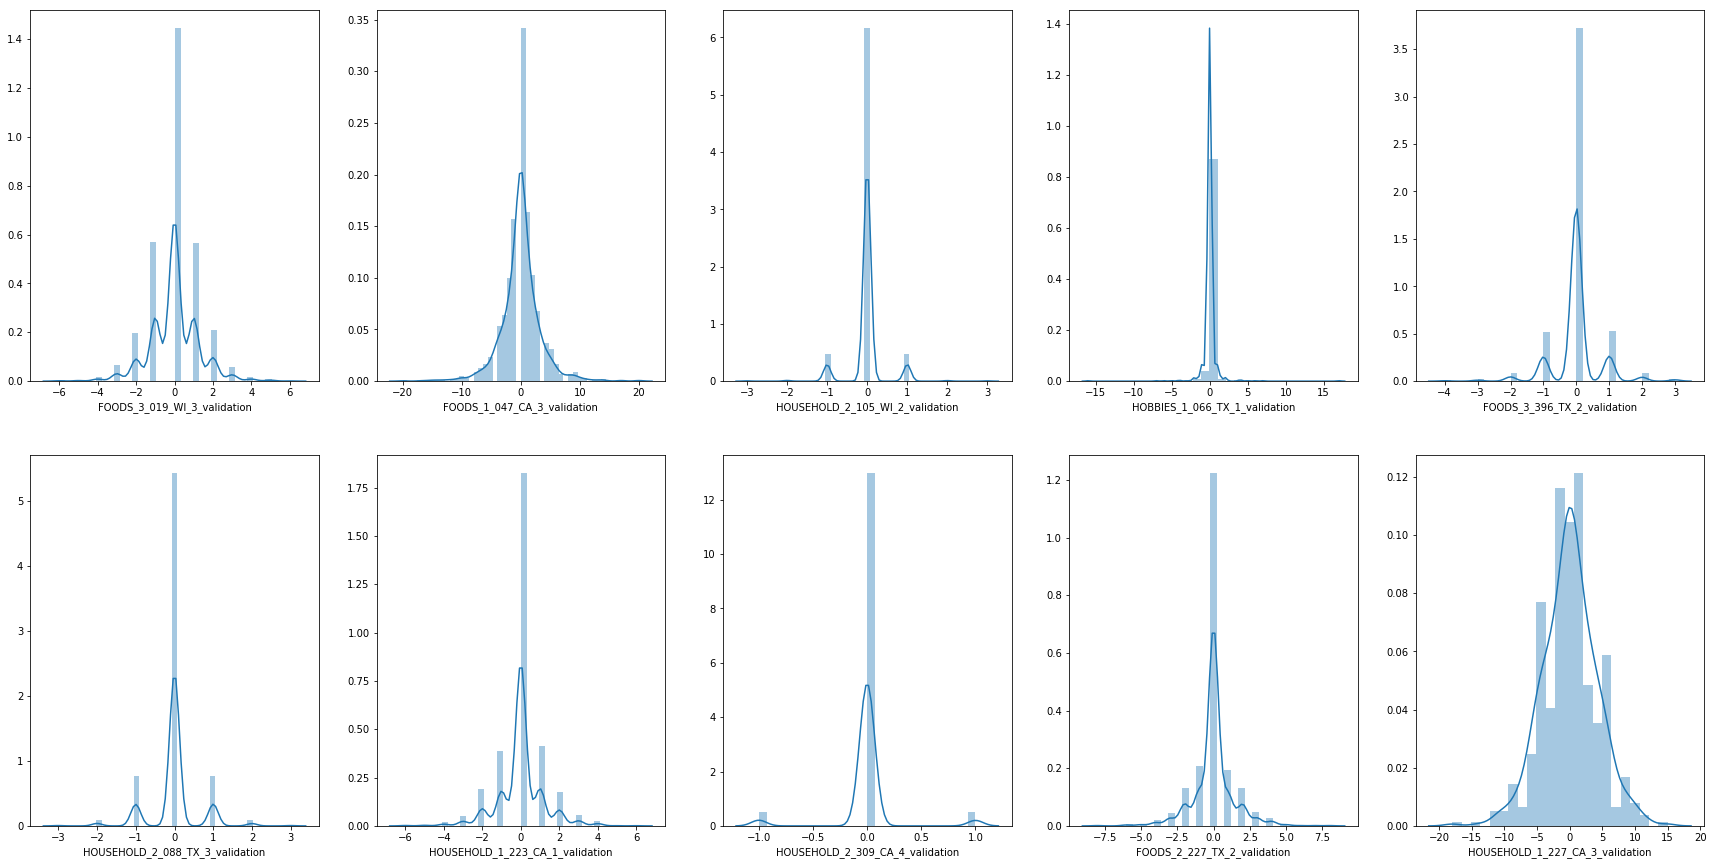

In [16]:
plt.figure(figsize=(30,15))
for i, col in enumerate(random.sample(item_ids, 10)):
    plt.subplot(2,5, i+1)
    sns.distplot(df3[col].dropna())

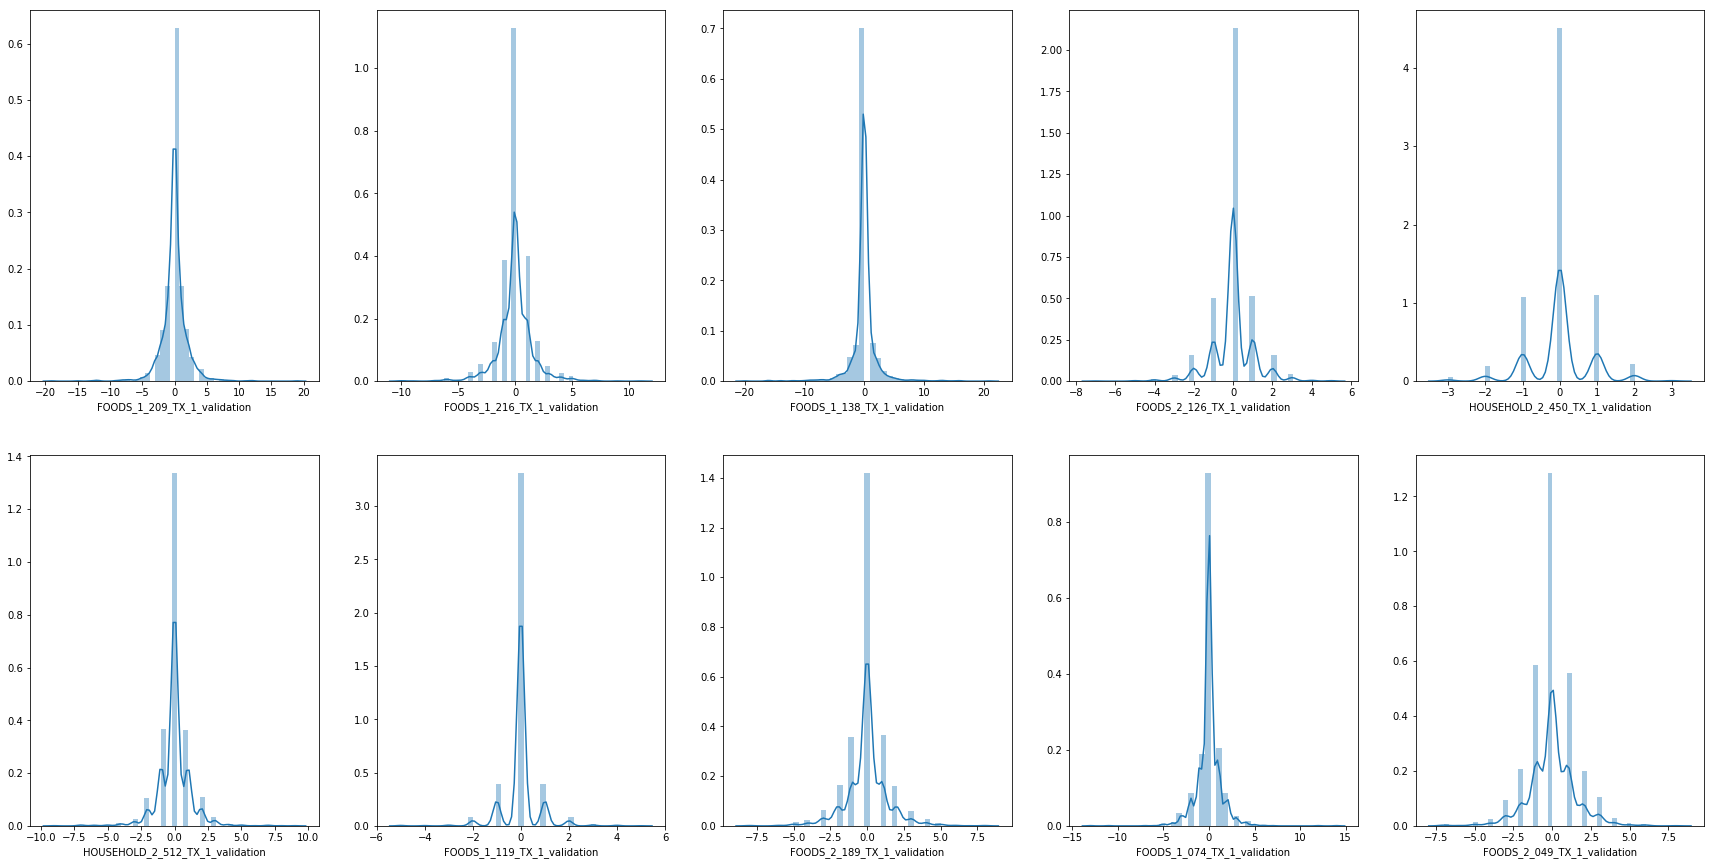

In [17]:
plt.figure(figsize=(30,15))
for i, col in enumerate(random.sample(df3.isnull().sum(0).sort_values().index.tolist()[:500], 10)):
    plt.subplot(2,5, i+1)
    sns.distplot(df3[col].dropna())

In [18]:
df3_std = df3.std(0)

In [19]:
tmp = pd.concat([
    df3_std, train_df[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]
], axis=1)
tmp.columns=['_diff', 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

In [20]:
tmp = pd.concat([
    tmp, df2.mean(0)
], axis=1)
tmp.columns=tmp.columns.tolist()[:-1]+['sell_mean']

In [21]:
tmp.head()

,_diff,id,item_id,dept_id,cat_id,store_id,state_id,sell_mean
id,,,,,,,,
HOBBIES_1_001_CA_1_validation,1.181687,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.589971
HOBBIES_1_002_CA_1_validation,0.807542,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0.278060
HOBBIES_1_003_CA_1_validation,0.890388,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0.353808
HOBBIES_1_004_CA_1_validation,2.522190,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1.750799
HOBBIES_1_005_CA_1_validation,1.767096,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1.026652


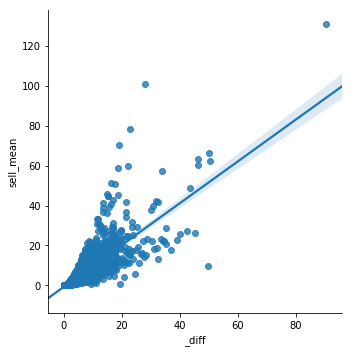

In [22]:
sns.lmplot(
    data=tmp, x='_diff', y='sell_mean'
)

In [23]:
tmp.groupby(['dept_id'])['_diff'].mean().sort_values()

dept_id
HOBBIES_2      0.854714
HOUSEHOLD_2    0.882770
HOBBIES_1      1.672997
HOUSEHOLD_1    1.922218
FOODS_2        1.932704
FOODS_1        2.256445
FOODS_3        2.846918
Name: _diff, dtype: float64

In [24]:
tmp.groupby(['dept_id'])['_diff'].std().sort_values()

dept_id
HOUSEHOLD_2    0.592015
HOBBIES_2      0.629986
FOODS_2        1.658943
HOUSEHOLD_1    1.804221
FOODS_1        1.857384
HOBBIES_1      2.105428
FOODS_3        3.556619
Name: _diff, dtype: float64

In [25]:
a = tmp.groupby(['item_id'])['_diff'].mean().sort_values()
a[:5], a[-5:]

(item_id
 HOBBIES_2_119      0.267033
 HOUSEHOLD_2_392    0.337119
 HOBBIES_1_052      0.339106
 HOUSEHOLD_2_042    0.339989
 HOUSEHOLD_2_087    0.341748
 Name: _diff, dtype: float64, item_id
 FOODS_3_711    17.302764
 FOODS_3_007    17.447768
 FOODS_3_752    18.463333
 FOODS_3_234    21.794791
 FOODS_3_090    40.281940
 Name: _diff, dtype: float64)

In [26]:
a = tmp.groupby(['item_id'])['_diff'].std().sort_values()
a[:5], a[-5:]

(item_id
 HOUSEHOLD_2_141    0.037170
 HOUSEHOLD_2_392    0.039676
 HOBBIES_2_119      0.047734
 HOUSEHOLD_2_087    0.050875
 HOBBIES_1_018      0.057133
 Name: _diff, dtype: float64, item_id
 FOODS_3_070        10.064691
 FOODS_3_007        10.308209
 FOODS_3_234        11.534410
 HOUSEHOLD_1_474    14.336323
 FOODS_3_090        22.716859
 Name: _diff, dtype: float64)

### 差分1

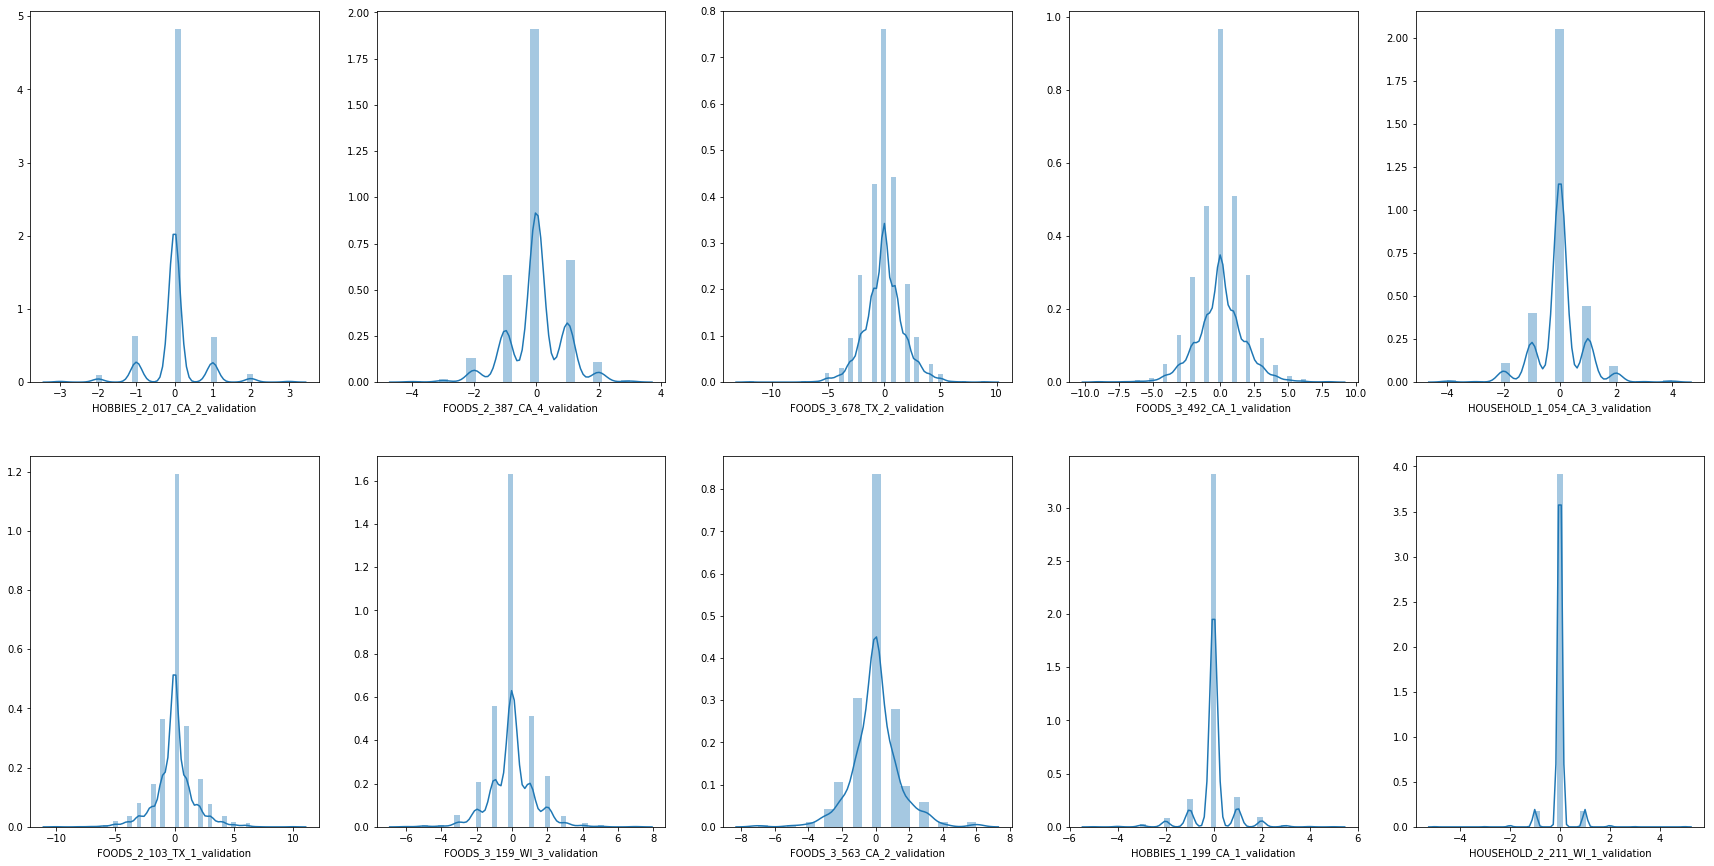

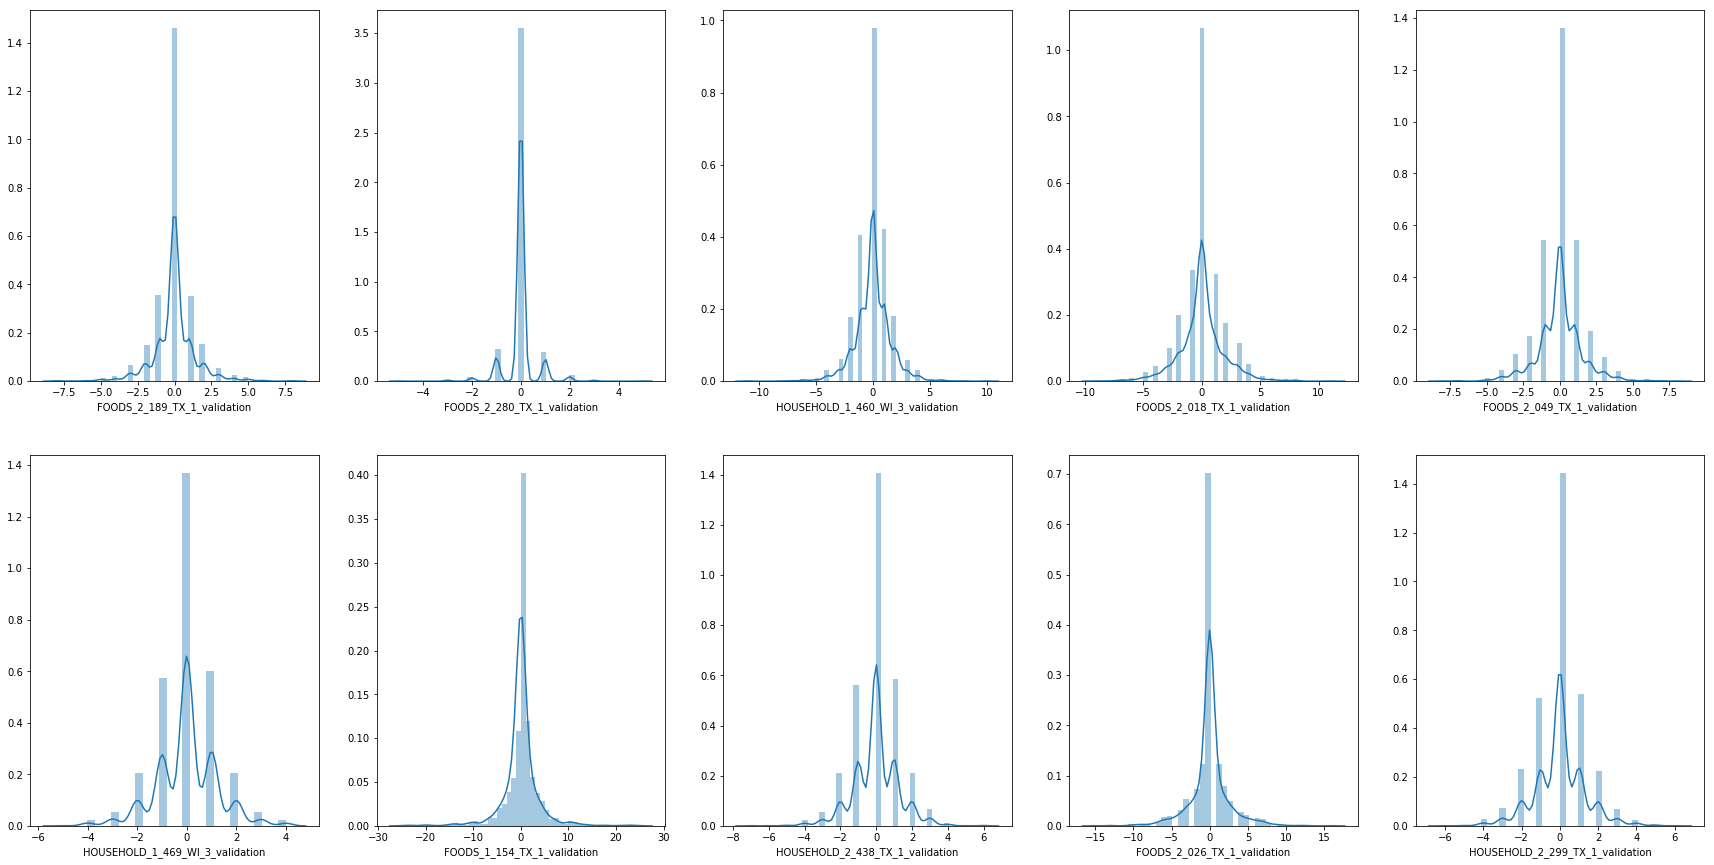

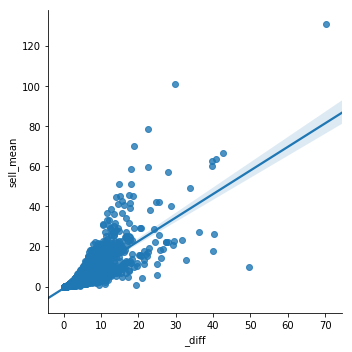

In [27]:
df3 = df2.diff(1)
df3 = df3.astype(float)

plt.figure(figsize=(30,15))
for i, col in enumerate(random.sample(item_ids, 10)):
    plt.subplot(2,5, i+1)
    sns.distplot(df3[col].dropna())
    
plt.figure(figsize=(30,15))
for i, col in enumerate(random.sample(df3.isnull().sum(0).sort_values().index.tolist()[:500], 10)):
    plt.subplot(2,5, i+1)
    sns.distplot(df3[col].dropna())
    
df3_std = df3.std(0)
tmp = pd.concat([
    df3_std, train_df[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]
], axis=1)
tmp.columns=['_diff', 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

tmp = pd.concat([
    tmp, df2.mean(0)
], axis=1)
tmp.columns=tmp.columns.tolist()[:-1]+['sell_mean']

sns.lmplot(
    data=tmp, x='_diff', y='sell_mean'
)

In [28]:
gc.collect()

89038

#### 売り上げの分析

In [35]:
v = df2.values.flatten()

In [36]:
v = v.astype(float)

In [44]:
v = v[~np.isnan(v)]

In [50]:
len(v)

46027957

In [53]:
a = v[random.sample([i for i in range(len(v))], 100000)]

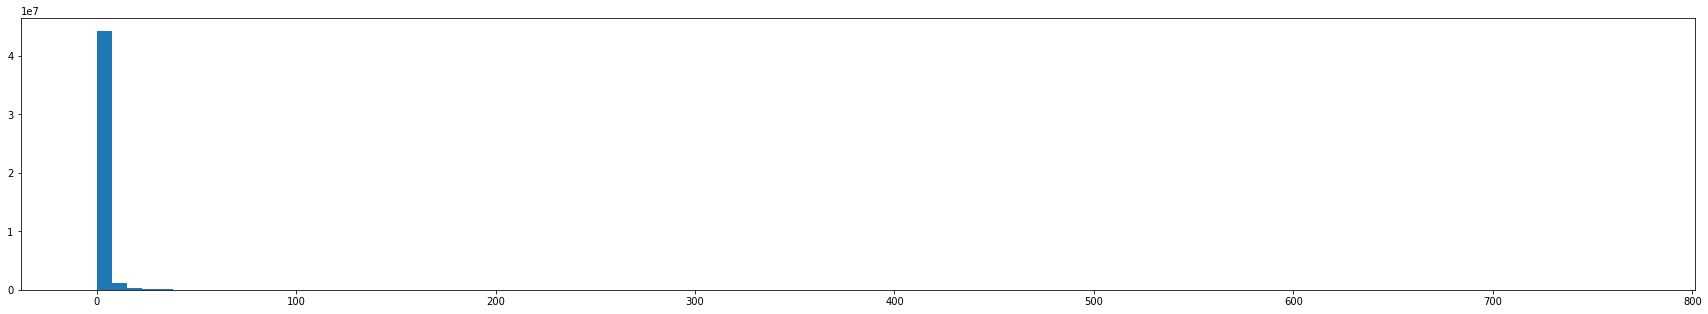

In [68]:
plt.figure(figsize=(30,5))
plt.hist(v, bins=100)
plt.show()

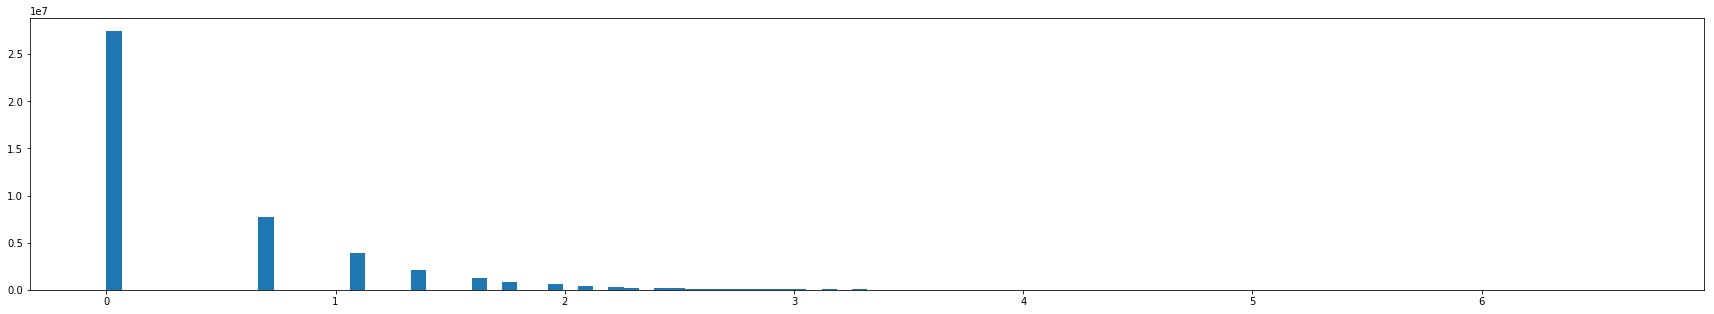

In [69]:
plt.figure(figsize=(30,5))
plt.hist(np.log1p(v), bins=100)
plt.show()

In [65]:
v.max()

763.0

In [66]:
v.std()

4.310440246021876

In [67]:
v.mean()

1.4272936120106308

In [70]:
np.log1p(v).max()

6.638567789166521

In [71]:
np.log1p(v).std()

0.7241156955406577

In [72]:
np.log1p(v).mean()

0.4934364811956391

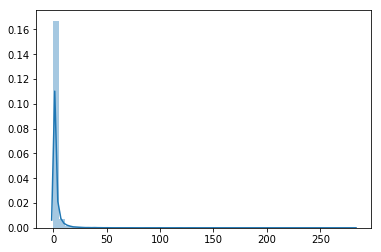

In [55]:
sns.distplot(a)

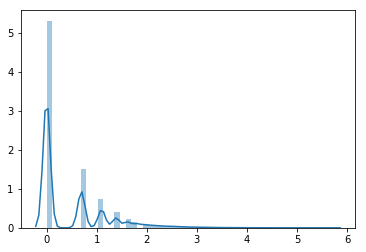

In [54]:
sns.distplot(np.log1p(a))

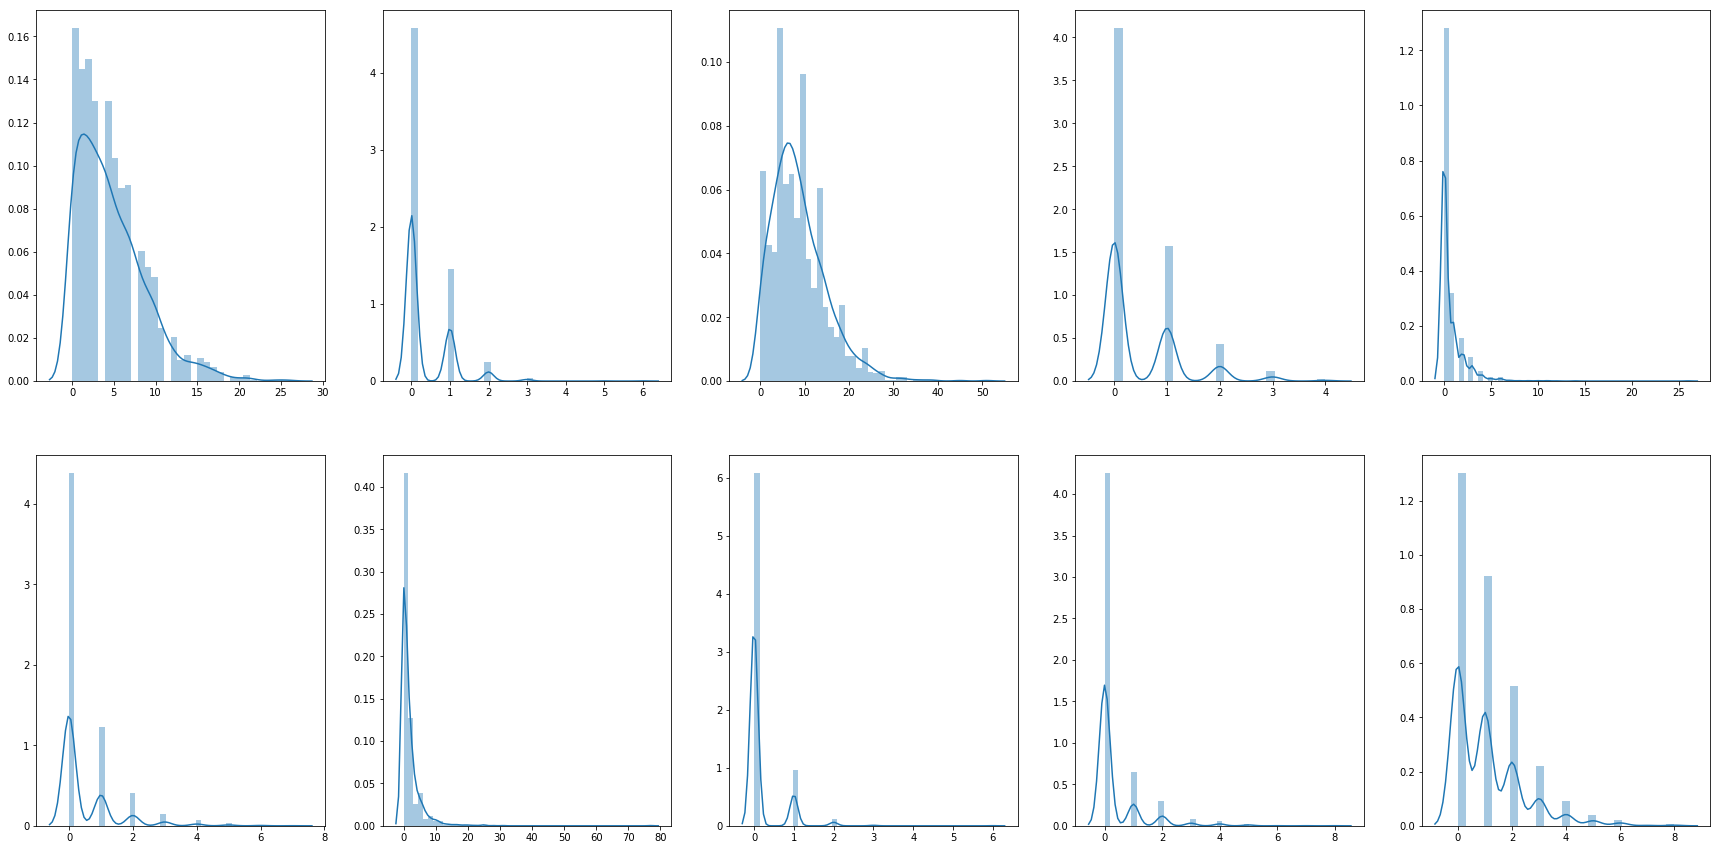

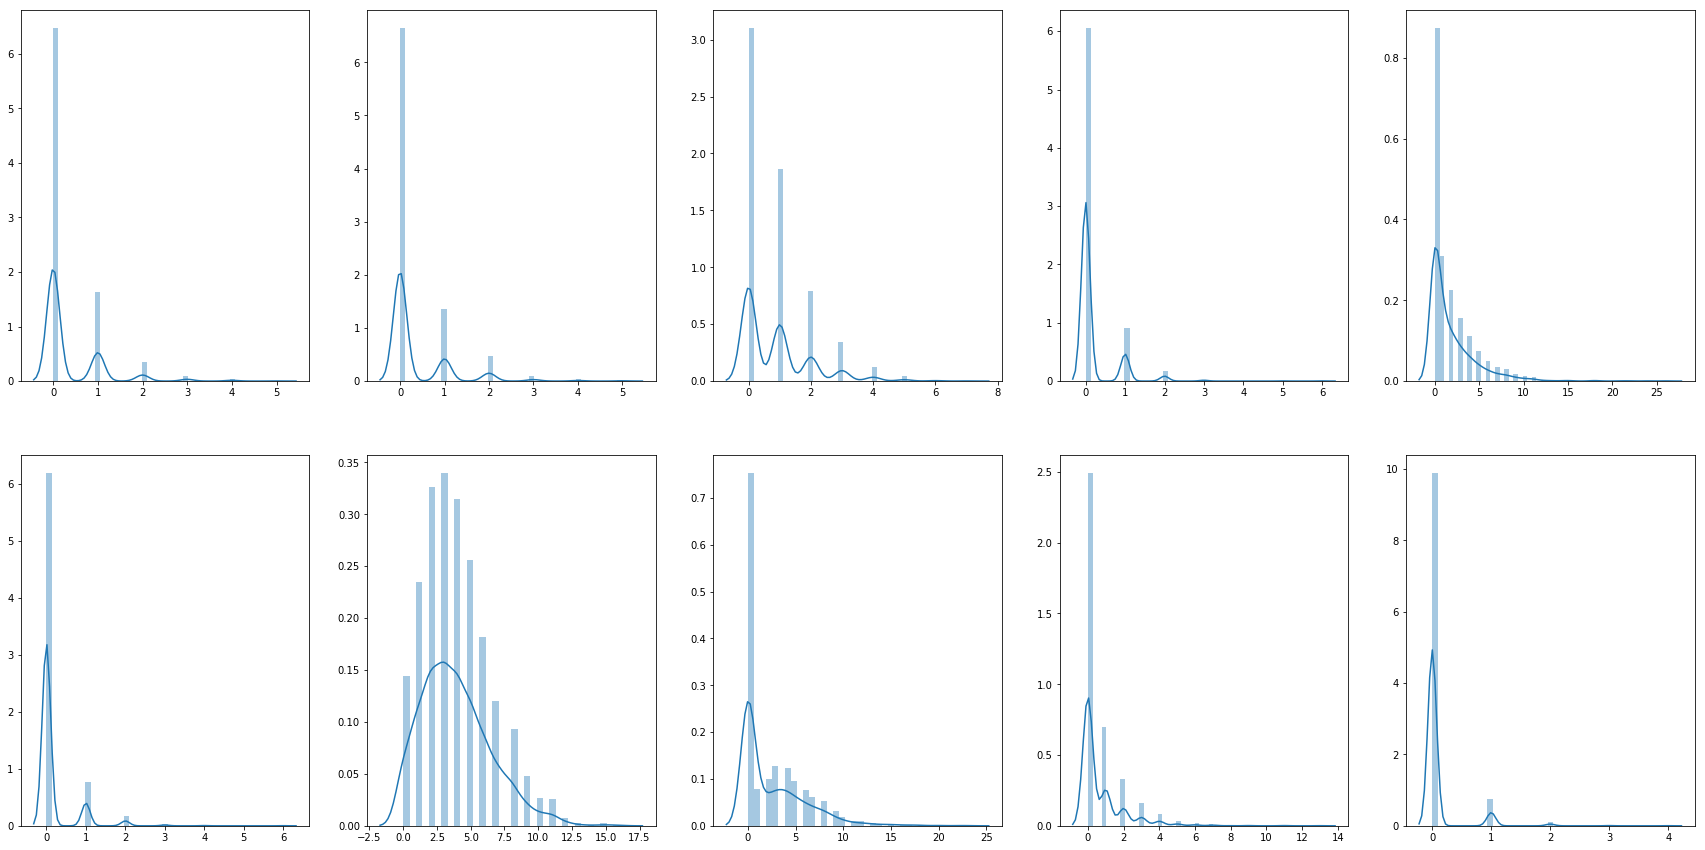

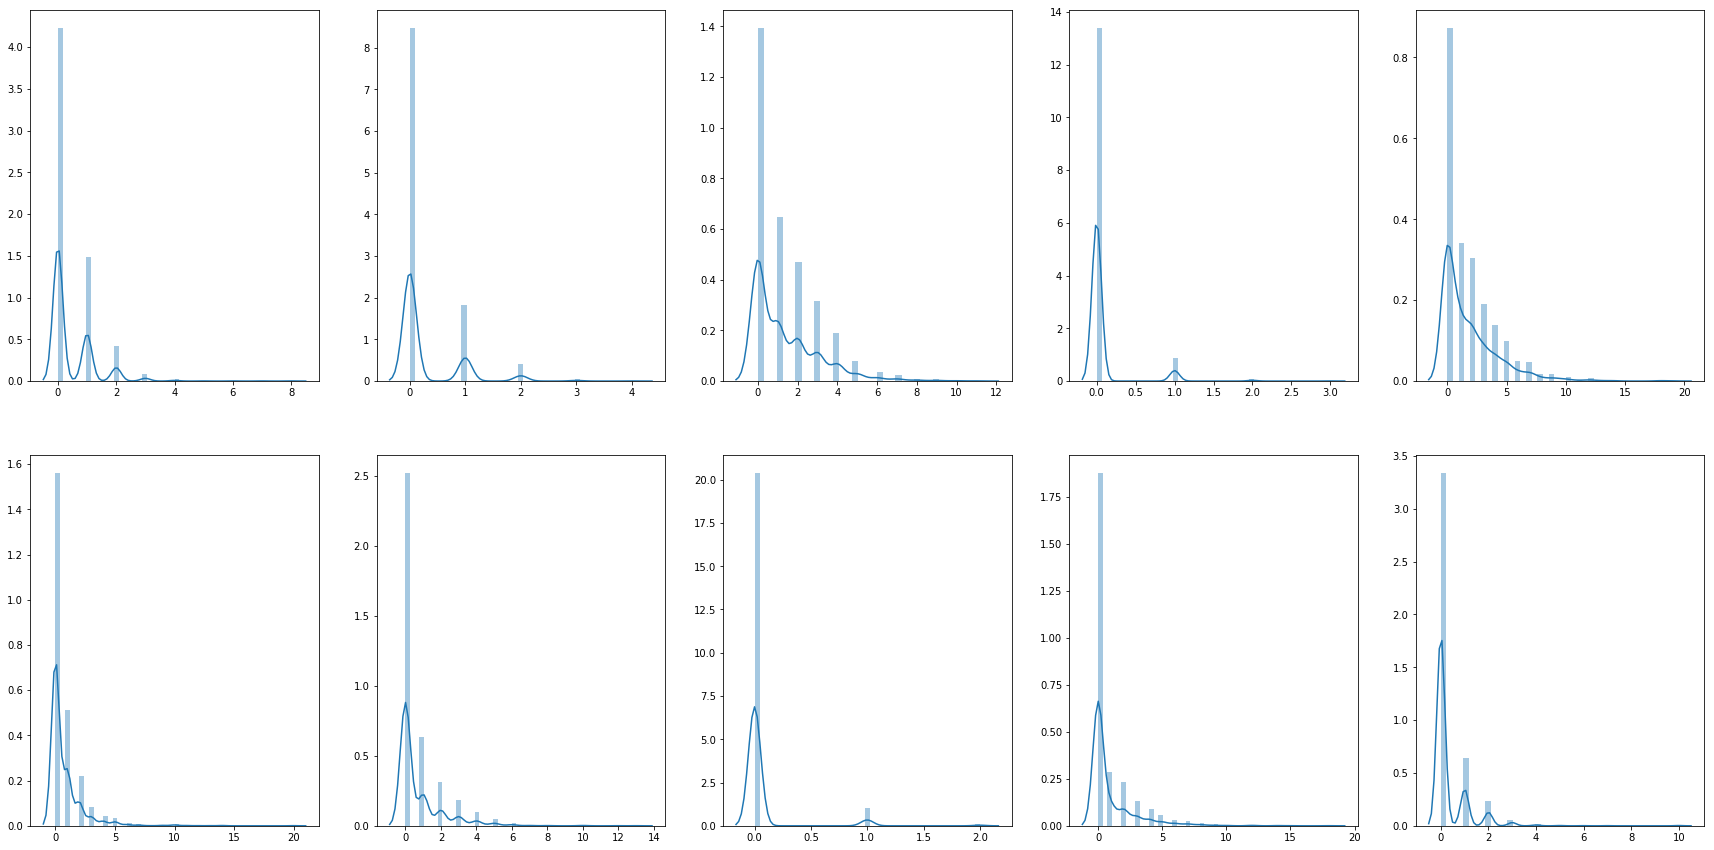

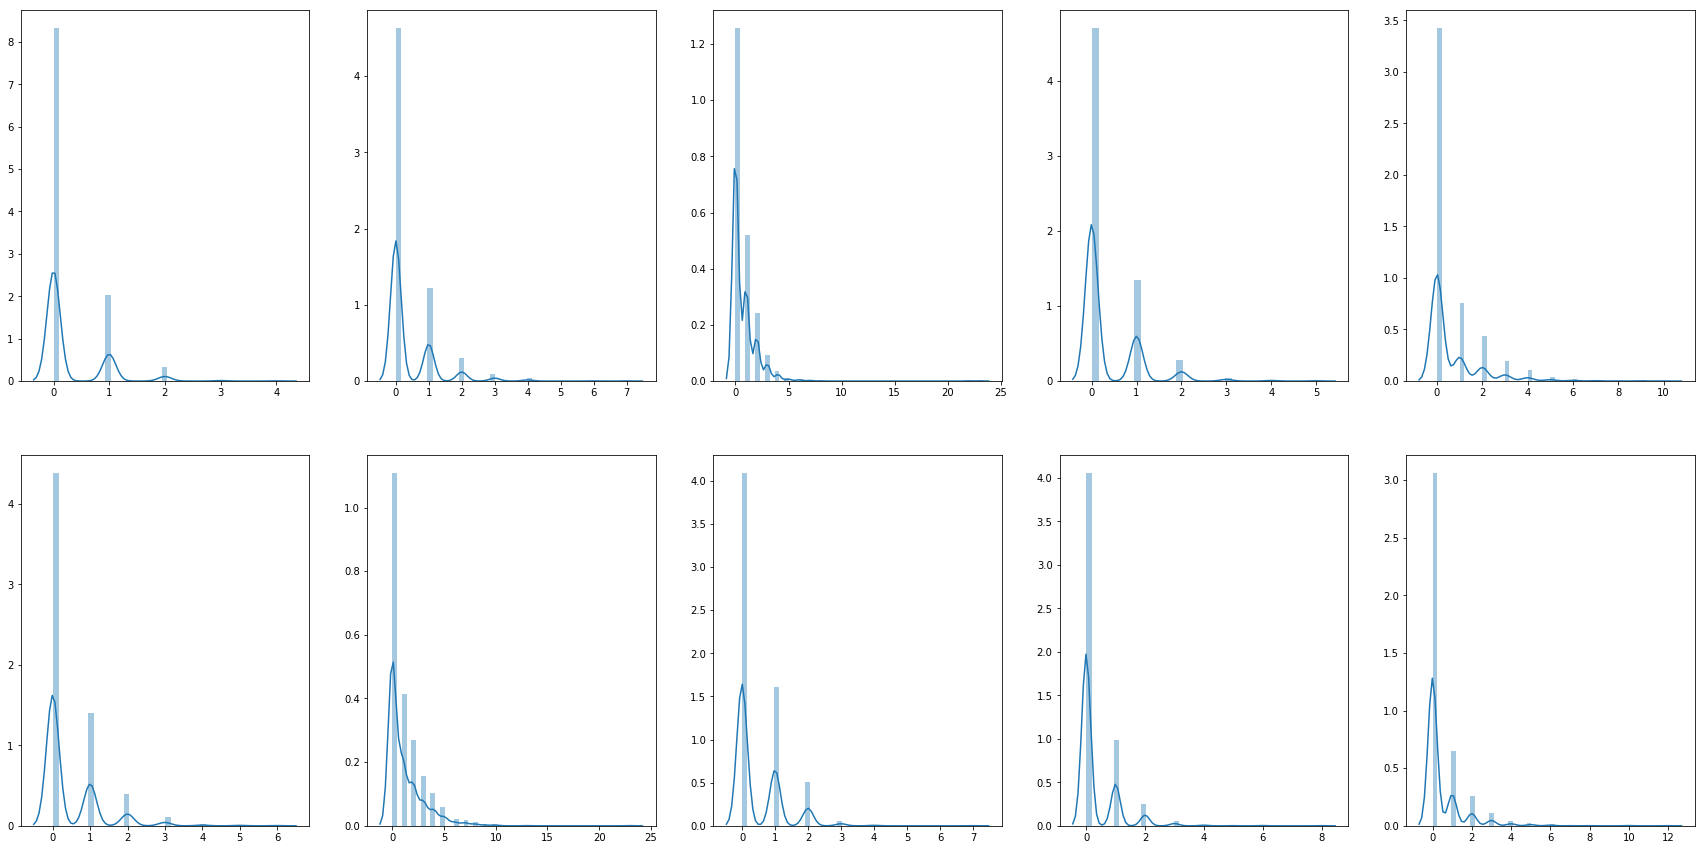

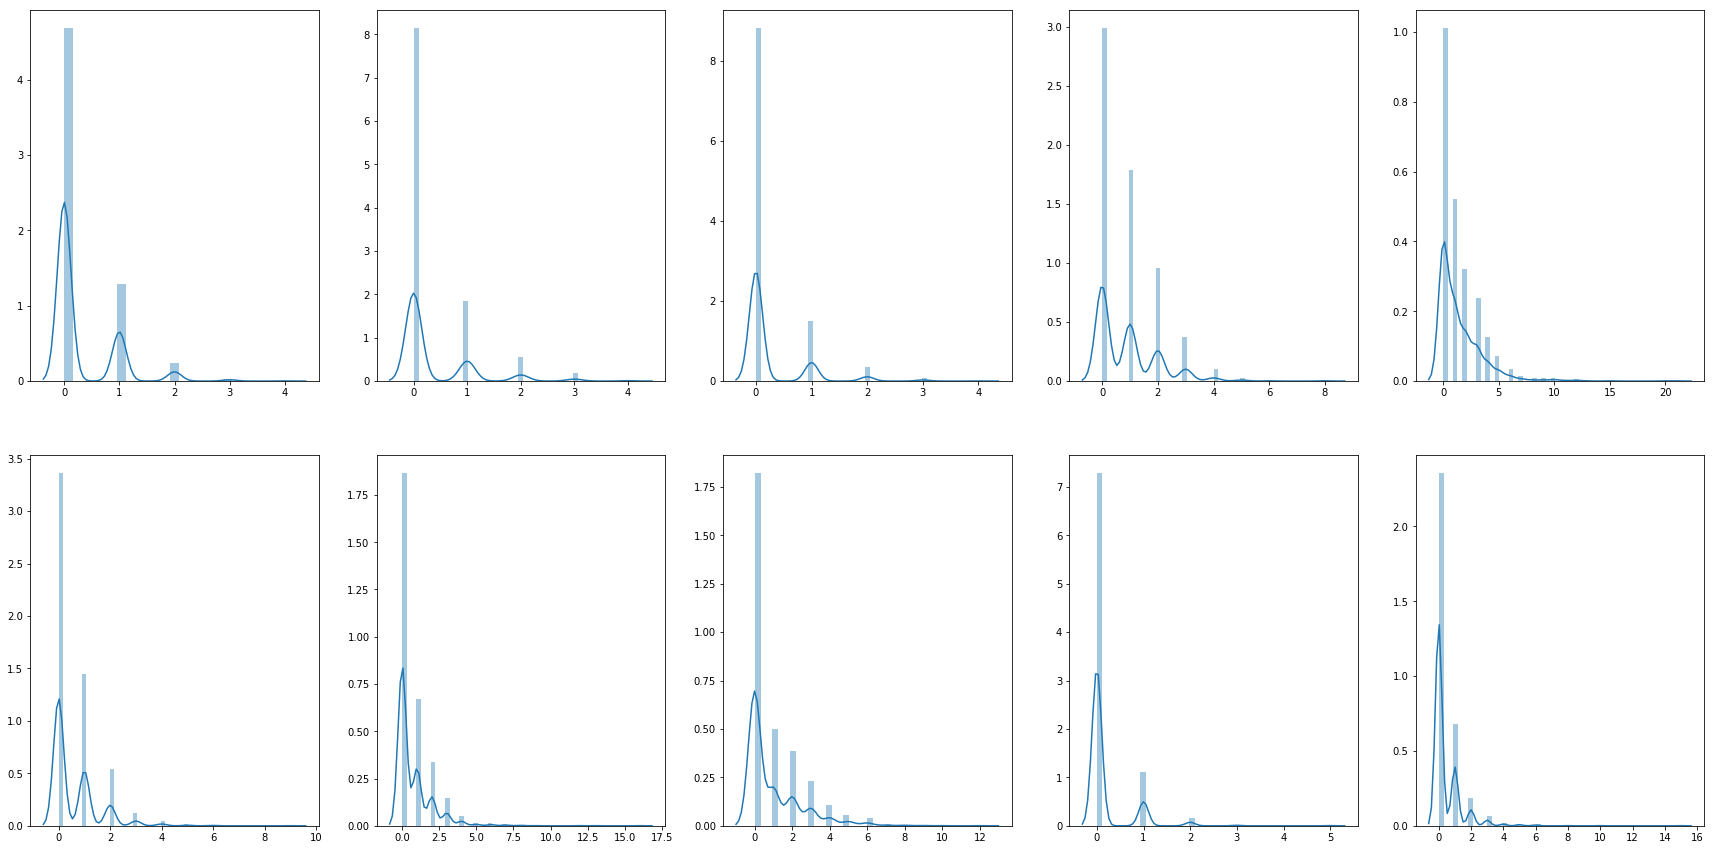

In [83]:
for _ in range(5):
    plt.figure(figsize=(30,15))
    for i, col in enumerate(random.sample(df2.isnull().sum(0).sort_values().index.tolist()[:500], 10)):
        plt.subplot(2,5, i+1)
        sns.distplot(df2[col].dropna().values.astype(float))

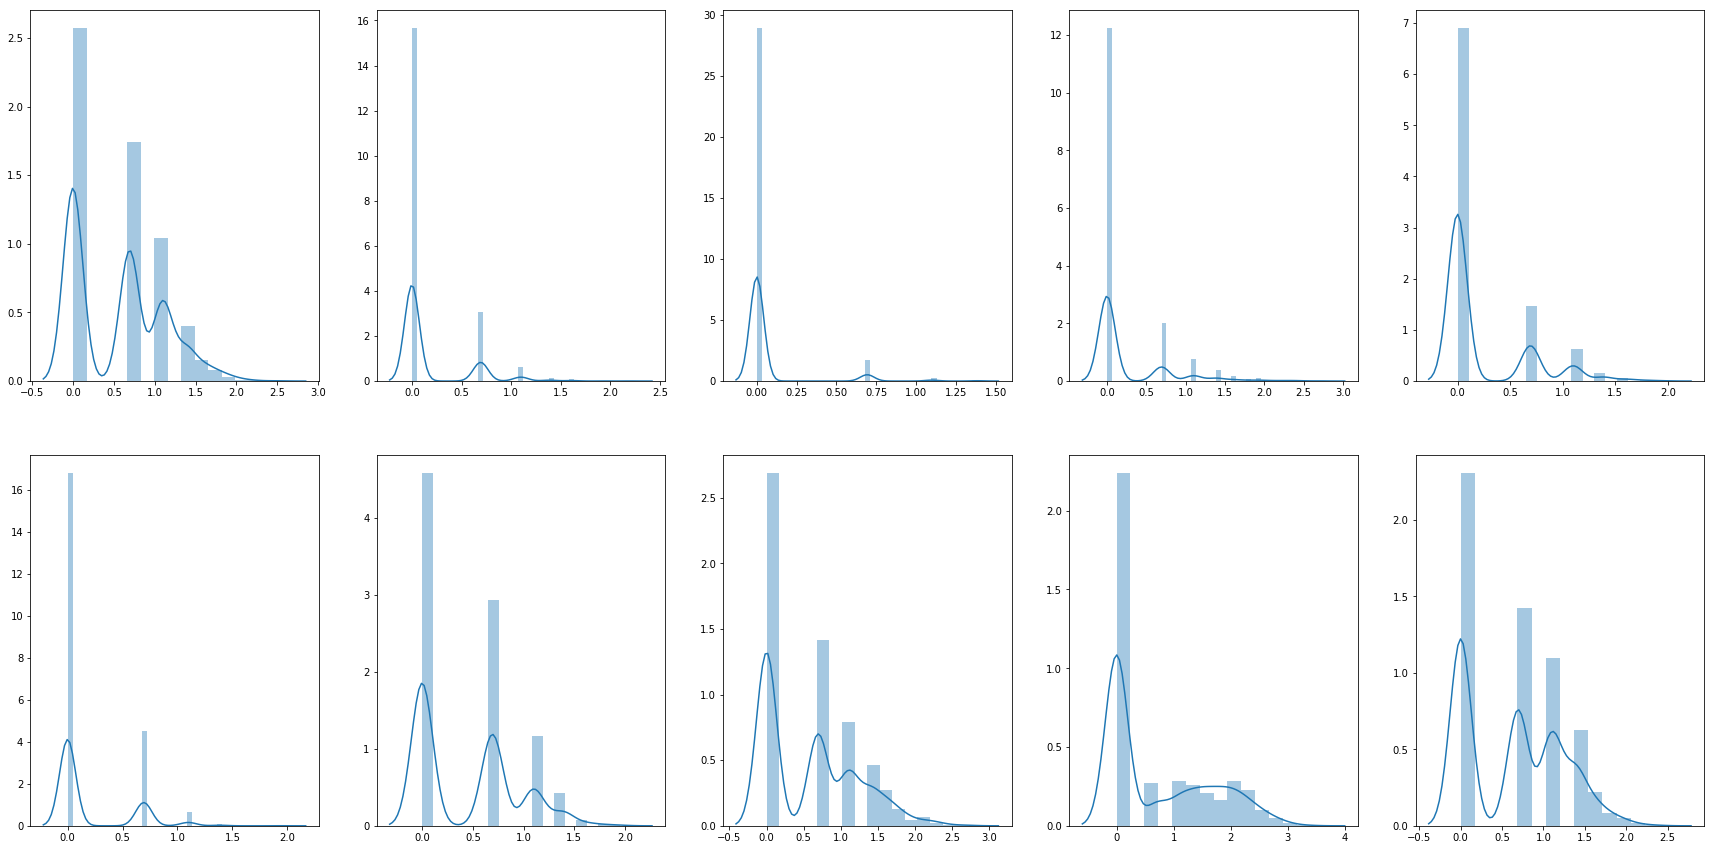

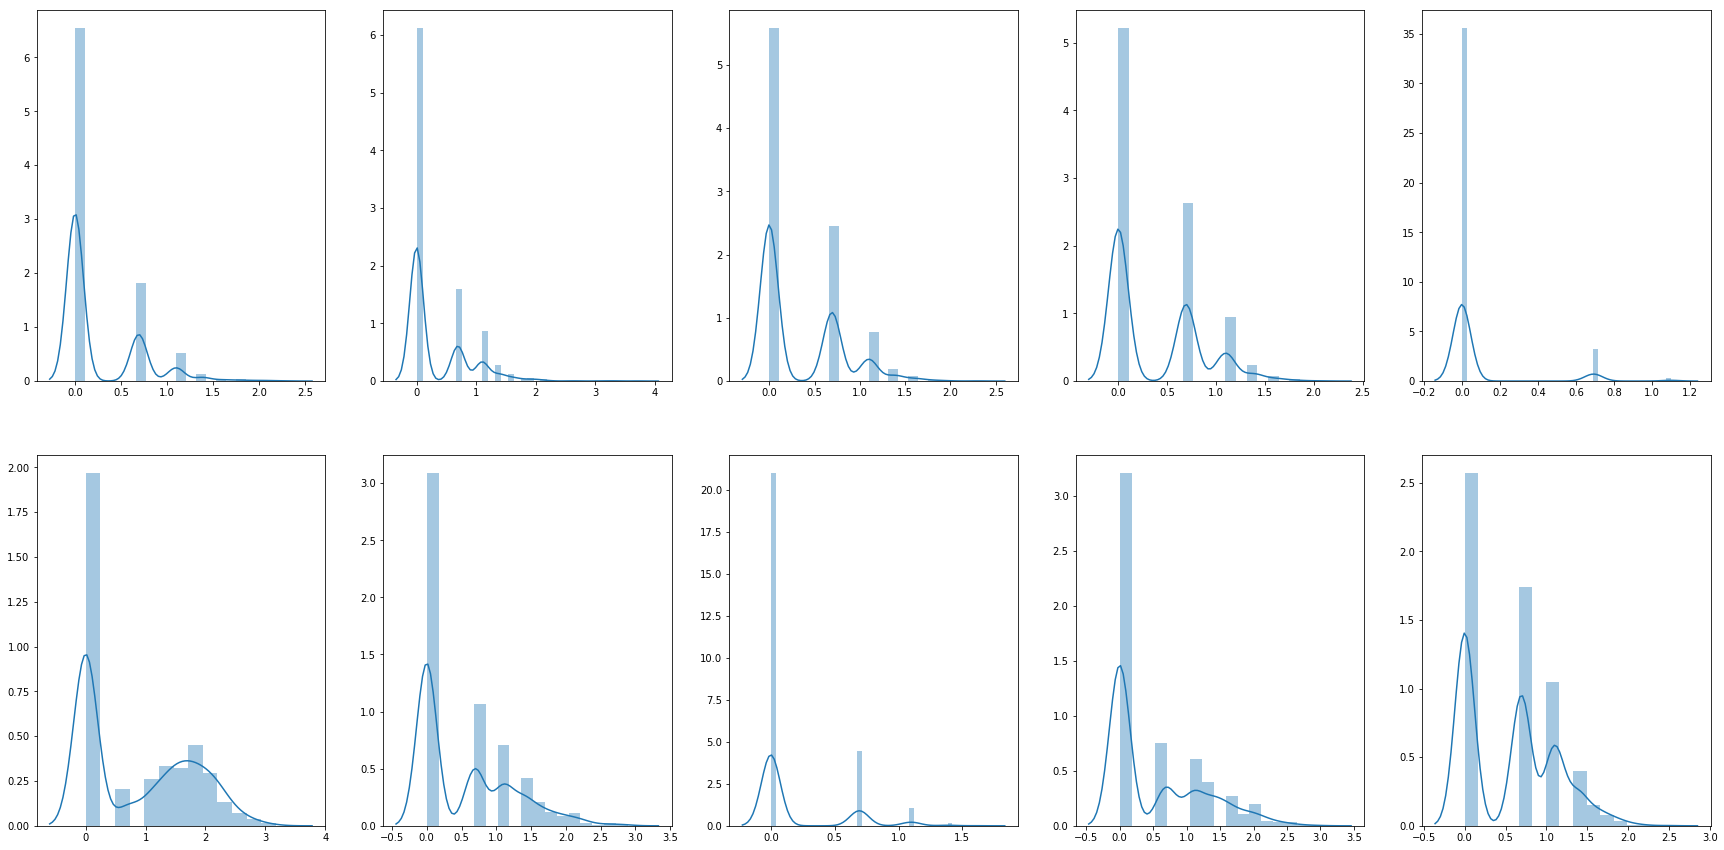

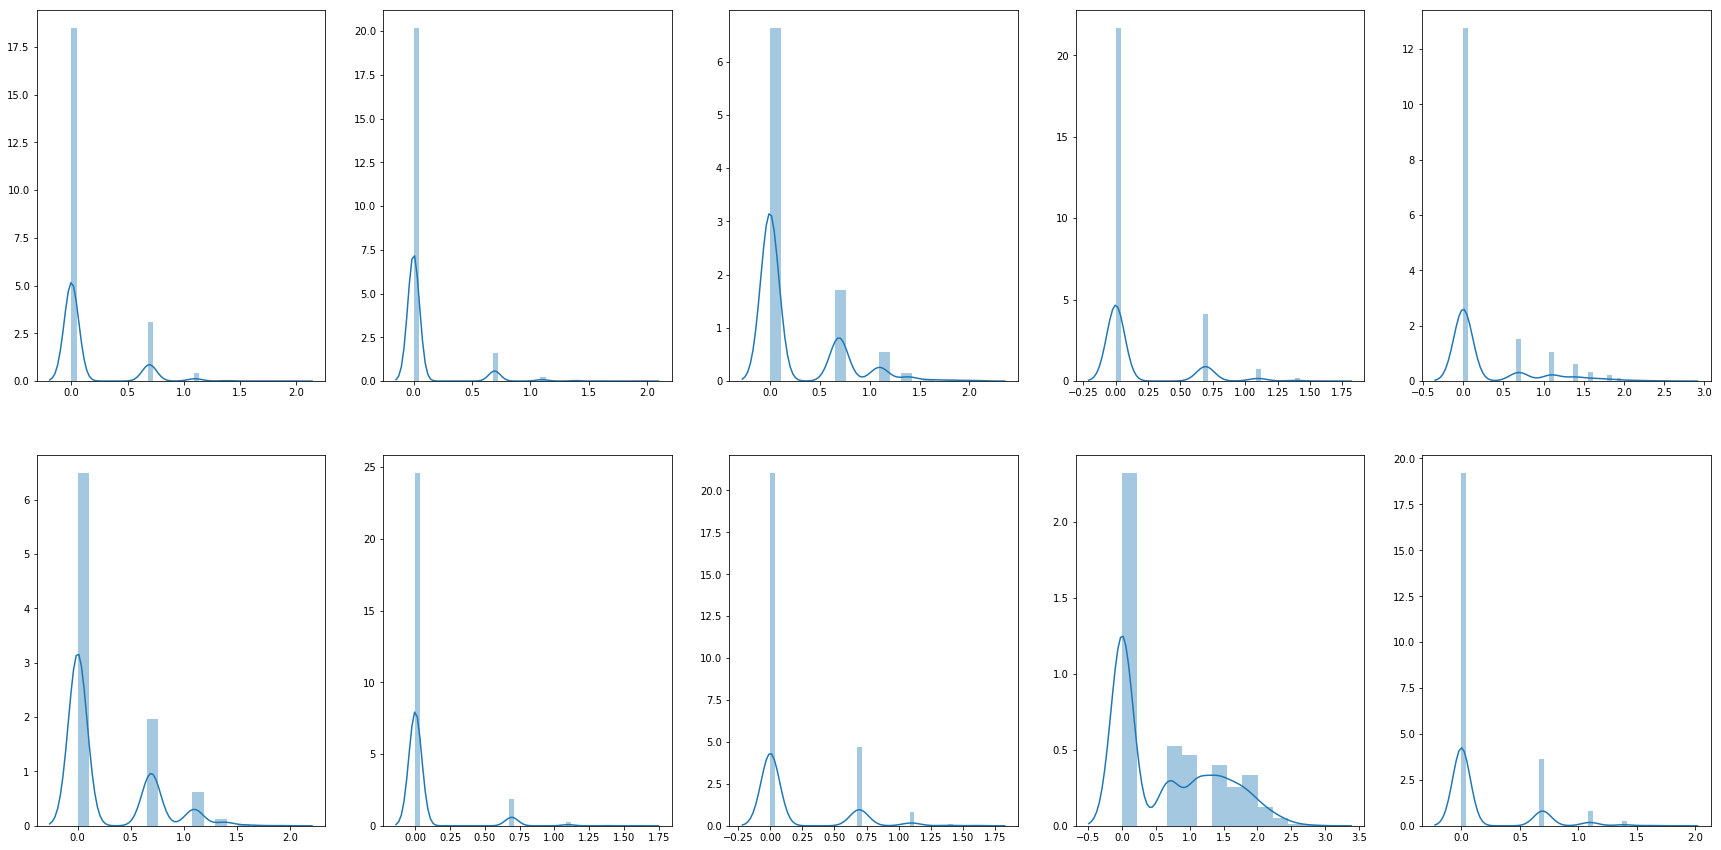

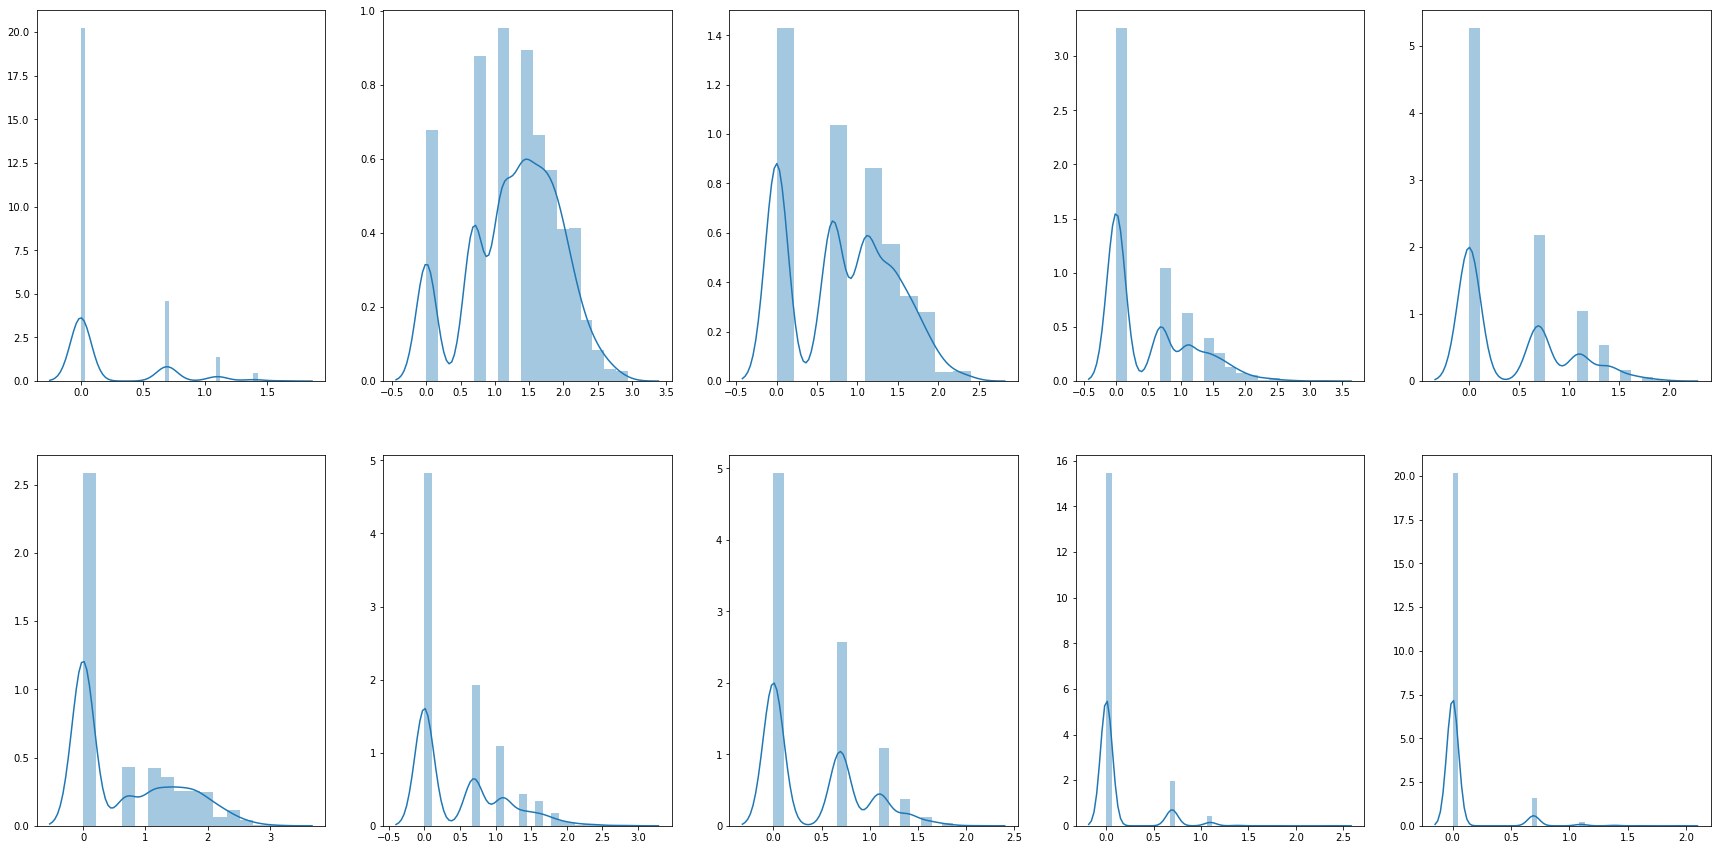

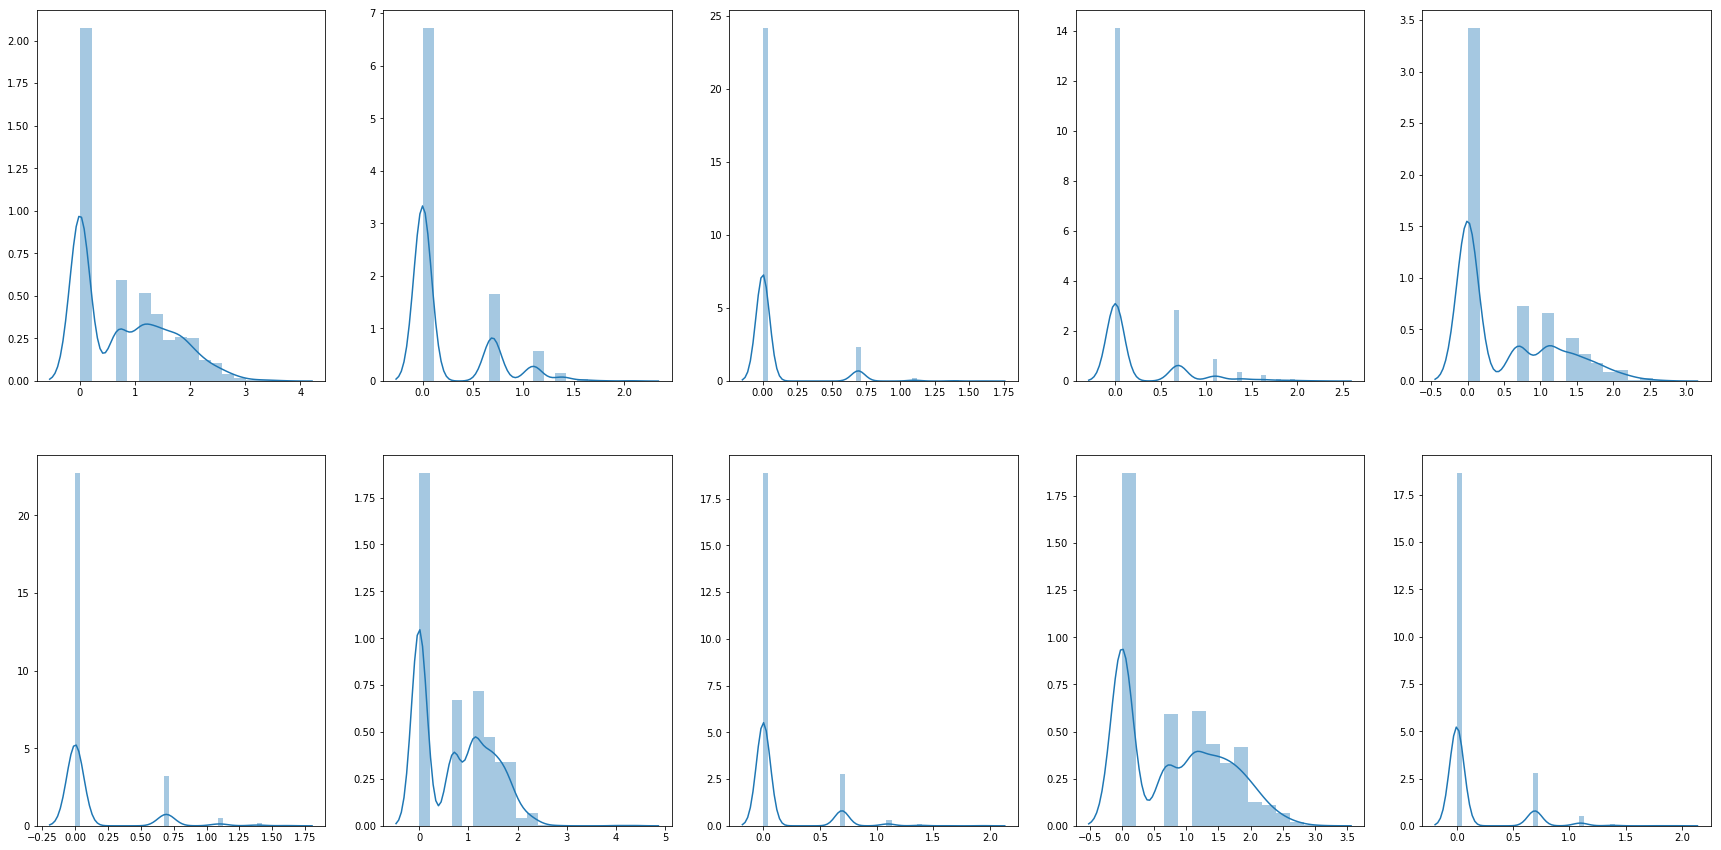

In [84]:
for _ in range(5):
    plt.figure(figsize=(30,15))
    for i, col in enumerate(random.sample(df2.isnull().sum(0).sort_values().index.tolist()[:500], 10)):
        plt.subplot(2,5, i+1)
        sns.distplot(np.log1p(df2[col].dropna().values.astype(float)))

In [16]:
df2 = df2.T.astype(float)

In [19]:
df2.reset_index(inplace=True)

In [25]:
d = train_df[['item_id', 'dept_id', 'state_id', 'store_id']].to_dict()

In [26]:
for key, value in d.items():
    df2[key] = df2.id.map(value)

In [53]:
a = df2.groupby(['state_id', 'store_id', 'dept_id'])[d_cols].std().reset_index().sort_values('dept_id')

In [56]:
a.index = a.state_id+'_'+a.store_id+'_'+a.dept_id

In [57]:
a[d_cols].sum(1)

CA_CA_1_FOODS_1        5861.171397
CA_CA_4_FOODS_1        4034.120341
TX_TX_1_FOODS_1        4216.240104
WI_WI_2_FOODS_1        7115.300927
TX_TX_2_FOODS_1        6461.140756
                          ...     
CA_CA_3_HOUSEHOLD_2    2499.295273
CA_CA_2_HOUSEHOLD_2    2078.829657
CA_CA_1_HOUSEHOLD_2    1594.059062
WI_WI_1_HOUSEHOLD_2    1248.058302
WI_WI_3_HOUSEHOLD_2    1239.963562
Length: 70, dtype: float64